In [1]:
%matplotlib inline
timeSz = 32
from MakeModels import *
encoder = makeEncoder(timeSz)
decoder = makeDecoder()
autoencoder = makeAutoencoder(encoder,decoder)

autoencoder.load_weights('/home/ubuntu/SoftRobotRepresentation/ModelPrettyGoodBottleneck25.h5', by_name=True)

nFeatures = autoencoder.layers[-2].output_shape[-1]+4

Using TensorFlow backend.


(1, 256, 256, 3)


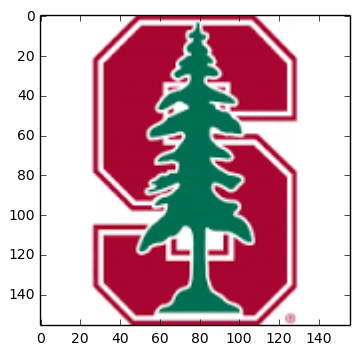

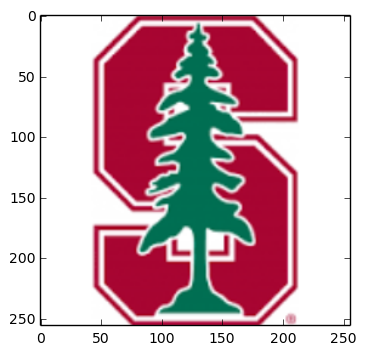

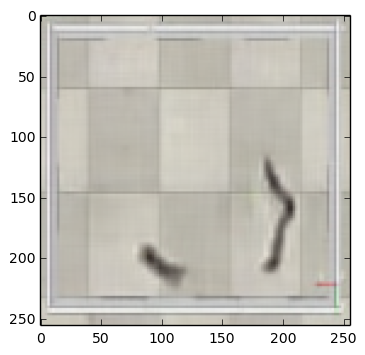

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import misc 

im = plt.imread('/home/ubuntu/SoftRobotRepresentation/Data/stanford.png')
plt.imshow(im)
im = misc.imresize(im, size=(256,256))
plt.figure()
plt.imshow(im)

im = np.expand_dims(im,axis=0)
print im.shape
im_out = autoencoder.predict(im, batch_size=1)
plt.figure()
plt.imshow(np.squeeze(im_out))
plt.imsave(fname='/home/ubuntu/SoftRobotRepresentation/Data/stanford_out.png',arr=np.squeeze(im_out))

In [2]:
## Let's test some learning rates
import numpy as np
from numpy import random
import math
from tqdm import tqdm
from IPython.core.debugger import Pdb
from matplotlib import pyplot as plt
import Constants as C

import pandas as pd


numEpochs = 50
numBatchesPerEpoch = 1000
nValBatches = 100

trainPath = "/home/ubuntu/SoftRobotRepresentation/Data/Training/0/"
valPath = "/home/ubuntu/SoftRobotRepresentation/Data/Validation/0/"

positionFiles = ['/home/ubuntu/SoftRobotRepresentation/Data/recordingRight.csv',
                 '/home/ubuntu/SoftRobotRepresentation/Data/recordingRight2.csv']

numFramesTrain = [21420,31430]
numFramesVal = [9180,13470]
numFrames = [e+f for e,f in zip(numFramesTrain,numFramesVal)]

posTables = [pd.read_csv(e) for e in positionFiles]

positionDataTrain = np.empty(shape=(0,2))
positionDataVal = np.empty(shape=(0,2))
for i in range(len(positionFiles)):
    positionData = posTables[i].as_matrix(columns=['x(m)','y(m)'])
    positionDataTrain = np.concatenate((positionDataTrain,positionData[:numFramesTrain[i],:]))
    positionDataVal = np.concatenate((positionDataVal,positionData[numFramesTrain[i]:numFrames[i],:]))
    
print str(positionDataTrain.shape) +" " + str(positionDataVal.shape)

paths = [trainPath,valPath]
positionDatas = [positionDataTrain, positionDataVal]
savePaths = ['/home/ubuntu/SoftRobotRepresentation/Data/trainFeats','/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy']

for idx,path in enumerate(paths):
    nfiles = len(os.listdir(path))
    files = ['%s%06d.jpg'%(path,i) for i in range(nfiles)]
    res = np.zeros(shape=(nfiles,nFeatures)) 
    for i in tqdm(range(int(math.floor(len(files)/C.batchSz))-1)):
        batch = np.zeros(shape=(C.batchSz,C.imDim,C.imDim,3))
        for j in range(C.batchSz):
            batch[j,:] = plt.imread(files[i*C.batchSz+j]).astype('float32')/255.0
        features = encoder.predict_on_batch(batch) 
        features = np.squeeze(features)
        res[i*C.batchSz:(i+1)*C.batchSz,:] = np.hstack((features,
                                                        positionDatas[idx][i*C.batchSz:(i+1)*C.batchSz,:],
                                                        positionDatas[idx][i*C.batchSz+C.predictAhead:(i+1)*C.batchSz+C.predictAhead,:]))
        
    np.save(savePaths[idx],res)

  0%|          | 0/1650 [00:00<?, ?it/s]

(52850, 2) (22650, 2)


100%|██████████| 706/706 [01:48<00:00,  6.49it/s]
